# Porovnavani dvou UBX GPS prijimacu


Tento notebook slouží k porovnávání záznamu z dvou GNSS přijímačů s podporou UBX nebo NMEA formátu. Původní použítí předpokládá jako vstupní data vyexportovaný GPS DUMP z ulog záznamu z PX4 autopilota. Z ulog formátu lze tato data získat pomocí [pyulog](https://github.com/ThunderFly-aerospace/pyulog/) skriptu.

Příkazem:

```
ulog_extract_gps_dump -i <cislo instance 0 nebo 1> -o <slozka pro vytovorene soubory>  <.ulog file>

```
Toto je potřeba provést pro všechny instance (v našem případě pro 0 nebo 1). 
Následně v druhém bloku uvést cestu, kde lze nalézt oba soubory. 

In [295]:
import os
import time
import pandas as pd
from ubx import UBXManager, UBX
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)

In [296]:
# f = '/home/roman/OwnCloudMLAB/TF_data/UAV/TF-G2/zkousky/Test_20201126_Zdiby_GSA/log/log_27_2020-11-26-12-17-40_{}_from_device.dat'
f = '/home/roman/OwnCloudMLAB/TF_data/UAV/TF-G2/zkousky/Test_20201124_zdiby/log/log_24_2020-11-24-14-18-44_{}_from_device.dat'

file1 = f.format(0)
file2 = f.format(1)

In [203]:
class MyManager(UBXManager):
    def __init__(self, *args, **kwargs):
        super(MyManager, self).__init__(*args, **kwargs)
        self.df = pd.DataFrame()
    
    def onUBXError(self, msgClass, msgId, errMsg):
        pass
        #print("UBX ERR {:02X}:{:02X} {}"
        #      .format(msgClass, msgId, errMsg))
    
    def onUBX(self, obj):
        #print(type(obj), obj)
        if isinstance(obj, UBX.NAV.PVT):
            d = obj.__dict__
            d.pop('_len')
            d.pop('_payload')
            s = pd.DataFrame.from_dict([d])
            self.df = pd.concat([self.df, s], ignore_index=True)
        
    def getDF(self):
        print(self.df.shape)
        return(self.df)

In [ ]:
infile = open(file1, 'rb')
manager1 = MyManager(infile, eofTimeout=0)
manager1.start()

infile = open(file2, 'rb')
manager2 = MyManager(infile, eofTimeout=0)
manager2.start()

while manager1.isAlive() or manager2.isAlive():
    time.sleep(0.5)
    
df1 = manager1.getDF()
df2 = manager2.getDF()
print("Done")

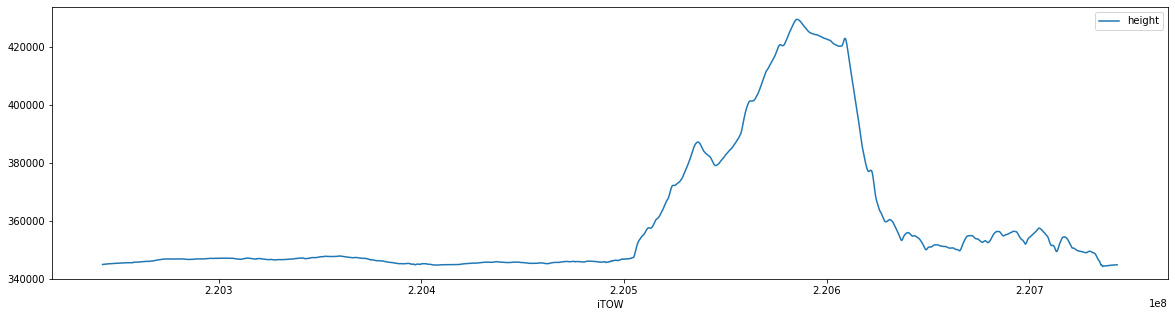

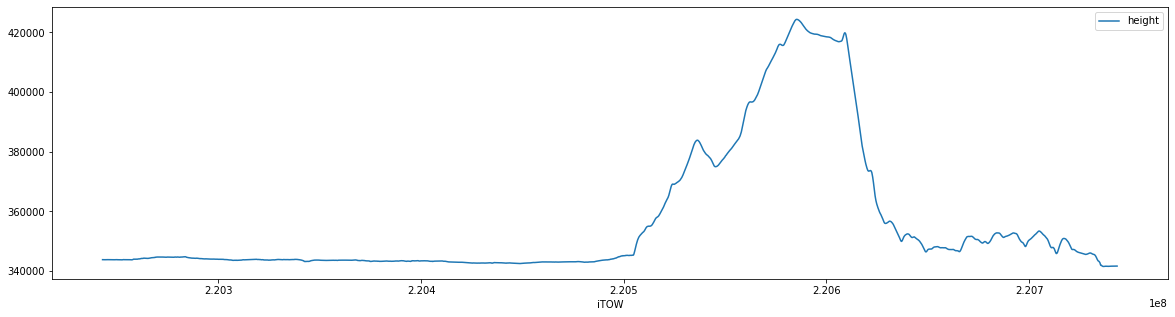

In [294]:
df1.plot(x='iTOW', y=['height'])
df2.plot(x='iTOW', y=['height'])

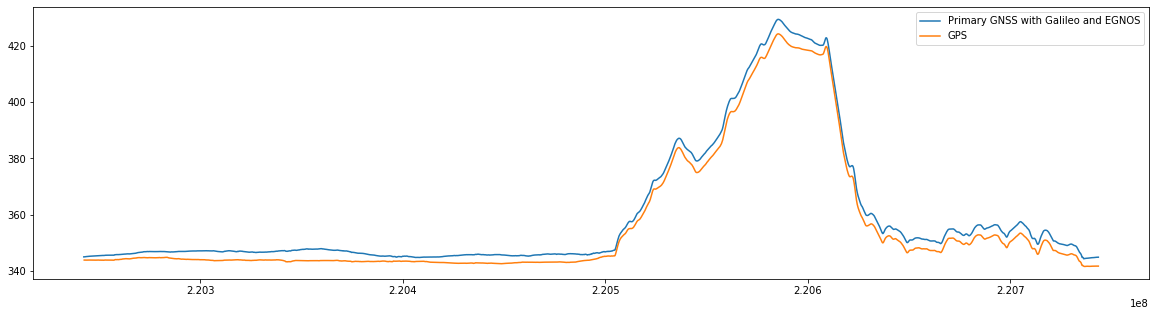

In [272]:
fig = plt.figure()

x = 'iTOW'
y = 'height'

plt.plot(df1[x], df1[y]/1000, label = 'Primary GNSS with Galileo and EGNOS')
plt.plot(df2[x], df2[y]/1000, label = 'GPS')

plt.legend()
plt.show()

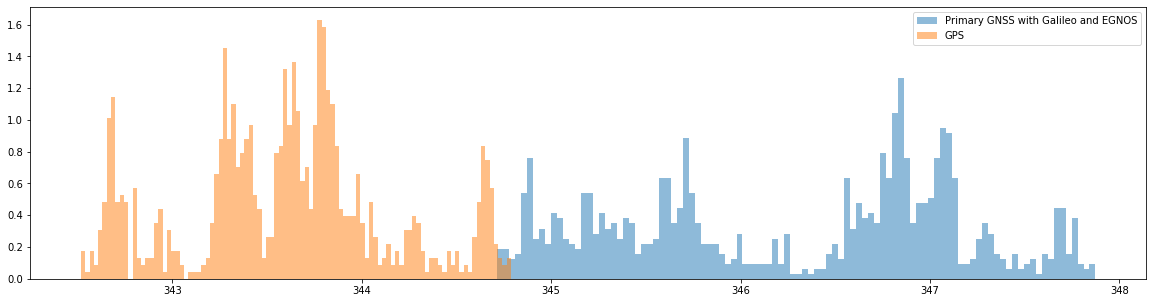

In [293]:
fig = plt.figure()

plt.hist(df1[y][:1000]/1000, 100, density=True, alpha=0.5, label = 'Primary GNSS with Galileo and EGNOS')
plt.hist(df2[y][:1000]/1000, 100, density=True, alpha=0.5, label = 'GPS')

plt.legend()
plt.show()